# Circle Loss

### 0-9で学習

In [1]:
import os
from typing import Tuple
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

import torch
from torch import nn, Tensor
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import ToTensor

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
def get_loader(is_train: bool, batch_size: int) -> DataLoader:
    trainset = datasets.MNIST(
                                root="./data",
                                train=is_train,
                                transform=ToTensor(),
                                download=True
                              )
    return DataLoader(trainset, batch_size=batch_size, shuffle=is_train)

# data loder
train_loader = get_loader(is_train=True, batch_size=64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
def visualize(features, labels, num_classes):
    # t-SNEで2次元に圧縮
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
    features = tsne.fit_transform(features)
    
    # カラーマップ
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    
    # 描画
    for i in range(num_classes):
        plt.plot(features[labels == i, 0], features[labels == i, 1], '.', c=colors[i])

    # グラフ設定
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper right')
    plt.show()

In [5]:
def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)

    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [6]:
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )

    def forward(self, input: Tensor) -> Tensor:
        feature = self.feature_extractor(input).mean(dim=[2, 3])
        return nn.functional.normalize(feature)

In [9]:
def train(criterion, epoch):
    print("Training... Epoch = %d" % epoch)
    for img, label in tqdm(train_loader):
        label += 1
        img, label = img.to(device), label.to(device)
        model.zero_grad()
        pred = model(img)
        loss = criterion(*convert_label_to_similarity(pred, label))
        loss.backward()
        optimizer.step()

In [11]:
# model
model = Model().to(device)

# optimzer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.8)

# CircleLoss
criterion = CircleLoss(m=0.25, gamma=80).to(device)

# Training
for epoch in range(10):
    sheduler.step()
    train(criterion, epoch+1)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training... Epoch = 1


100%|██████████| 938/938 [00:08<00:00, 116.56it/s]


Training... Epoch = 2


100%|██████████| 938/938 [00:07<00:00, 117.49it/s]


Training... Epoch = 3


100%|██████████| 938/938 [00:07<00:00, 118.06it/s]


Training... Epoch = 4


100%|██████████| 938/938 [00:07<00:00, 117.44it/s]


Training... Epoch = 5


100%|██████████| 938/938 [00:07<00:00, 117.47it/s]


Training... Epoch = 6


100%|██████████| 938/938 [00:07<00:00, 118.12it/s]


Training... Epoch = 7


100%|██████████| 938/938 [00:07<00:00, 117.76it/s]


Training... Epoch = 8


100%|██████████| 938/938 [00:07<00:00, 117.28it/s]


Training... Epoch = 9


100%|██████████| 938/938 [00:07<00:00, 117.46it/s]


Training... Epoch = 10


100%|██████████| 938/938 [00:07<00:00, 117.34it/s]


  1%|          | 51/5000 [00:00<00:05, 939.78it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


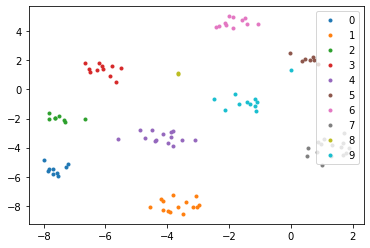

In [12]:
# data loader
val_loader = get_loader(is_train=False, batch_size=2)

# 保存用
all_features = []
all_labels = []

# 推論
for i, (img, label) in enumerate(tqdm(val_loader)):
    if i > 50: break
    img, label = img.to(device), label.to(device)
    pred = model(img)

    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)
visualize(all_features, all_labels, 10)

###0-4で学習

In [ ]:
def get_loader_0to4(batch_size: int) -> DataLoader:
    dataset = datasets.MNIST(root="./  data", train=True, transform=ToTensor(), download=True)
    mask = (dataset.targets == 0) | (dataset.targets == 1) | (dataset.targets == 2) | (dataset.targets == 3) | (dataset.targets == 4)
    dataset.data = dataset.data[mask]
    dataset.targets = dataset.targets[mask]

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = get_loader_0to4(64)

In [ ]:
# model
model = Model().to(device)

# optimzer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)

# CircleLoss
criterion = CircleLoss(m=0.25, gamma=80).to(device)

# Training
for epoch in range(20):
    sheduler.step()
    train(criterion, epoch+1)

100%|██████████| 5000/5000 [00:08<00:00, 616.81it/s]


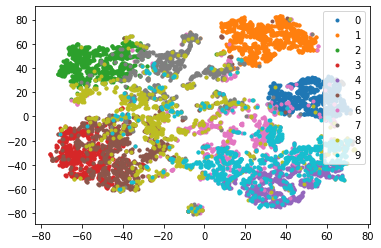

In [ ]:
# data loader
val_loader = get_loader(is_train=False, batch_size=2)

# 保存用
all_features = []
all_labels = []

# 推論
for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)

    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)
visualize(all_features, all_labels, 10)

### 0-7で学習

In [ ]:
def get_loader_0to7(batch_size: int) -> DataLoader:
    dataset = datasets.MNIST(root="./  data", train=True, transform=ToTensor(), download=True)
    mask = (dataset.targets == 0) | (dataset.targets == 1) | (dataset.targets == 2) | (dataset.targets == 3) | (dataset.targets == 4) | (dataset.targets == 5) | (dataset.targets == 6) | (dataset.targets == 7)
    dataset.data = dataset.data[mask]
    dataset.targets = dataset.targets[mask]

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = get_loader_0to7(64)

In [ ]:
# model
model = Model().to(device)

# optimzer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)

# CircleLoss
criterion = CircleLoss(m=0.25, gamma=80).to(device)

# Training
for epoch in range(20):
    sheduler.step()
    train(criterion, epoch+1)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training... Epoch = 1


100%|██████████| 754/754 [00:09<00:00, 75.76it/s]


Training... Epoch = 2


100%|██████████| 754/754 [00:09<00:00, 76.74it/s]


Training... Epoch = 3


100%|██████████| 754/754 [00:09<00:00, 75.96it/s]


Training... Epoch = 4


100%|██████████| 754/754 [00:09<00:00, 75.47it/s]


Training... Epoch = 5


100%|██████████| 754/754 [00:09<00:00, 75.89it/s]


Training... Epoch = 6


100%|██████████| 754/754 [00:09<00:00, 75.97it/s]


Training... Epoch = 7


100%|██████████| 754/754 [00:09<00:00, 75.75it/s]


Training... Epoch = 8


100%|██████████| 754/754 [00:09<00:00, 76.67it/s]


Training... Epoch = 9


100%|██████████| 754/754 [00:09<00:00, 77.02it/s]


Training... Epoch = 10


100%|██████████| 754/754 [00:09<00:00, 76.85it/s]


Training... Epoch = 11


100%|██████████| 754/754 [00:09<00:00, 76.65it/s]


Training... Epoch = 12


100%|██████████| 754/754 [00:09<00:00, 76.62it/s]


Training... Epoch = 13


100%|██████████| 754/754 [00:09<00:00, 76.67it/s]


Training... Epoch = 14


100%|██████████| 754/754 [00:09<00:00, 76.55it/s]


Training... Epoch = 15


100%|██████████| 754/754 [00:09<00:00, 76.50it/s]


Training... Epoch = 16


100%|██████████| 754/754 [00:09<00:00, 76.46it/s]


Training... Epoch = 17


100%|██████████| 754/754 [00:09<00:00, 76.85it/s]


Training... Epoch = 18


100%|██████████| 754/754 [00:09<00:00, 76.11it/s]


Training... Epoch = 19


100%|██████████| 754/754 [00:09<00:00, 75.56it/s]


Training... Epoch = 20


100%|██████████| 754/754 [00:09<00:00, 75.48it/s]


100%|██████████| 5000/5000 [00:08<00:00, 612.82it/s]


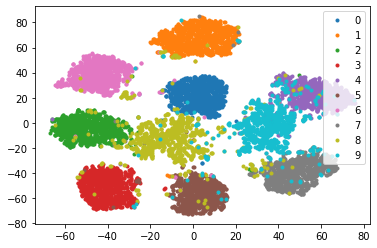

In [ ]:
# data loader
val_loader = get_loader(is_train=False, batch_size=2)

# 保存用
all_features = []
all_labels = []

# 推論
for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)

    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)
visualize(all_features, all_labels, 10)

#ArcFace

### 0-9で学習

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import math


class ArcMarginProduct(nn.Module):
	r"""Implement of large margin arc distance: :
		Args:
			in_features: size of each input sample
			out_features: size of each output sample
			s: norm of input feature
			m: margin
			cos(theta + m)
		"""
	def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
		super(ArcMarginProduct, self).__init__()
		self.in_features = in_features
		self.out_features = out_features
		self.s = s
		self.m = m
		self.weight = Parameter(torch.FloatTensor(out_features, in_features))
		nn.init.xavier_uniform_(self.weight)

		self.easy_margin = easy_margin
		self.cos_m = math.cos(m)
		self.sin_m = math.sin(m)
		self.th = math.cos(math.pi - m)
		self.mm = math.sin(math.pi - m) * m

	def forward(self, input, label):
		# --------------------------- cos(theta) & phi(theta) ---------------------------
		cosine = F.linear(F.normalize(input), F.normalize(self.weight))
		sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
		phi = cosine * self.cos_m - sine * self.sin_m
		if self.easy_margin:
			phi = torch.where(cosine > 0, phi, cosine)
		else:
			phi = torch.where(cosine > self.th, phi, cosine - self.mm)
		# --------------------------- convert label to one-hot ---------------------------
		# one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
		one_hot = torch.zeros(cosine.size(), device='cuda')
		one_hot.scatter_(1, label.view(-1, 1).long(), 1)
		# -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
		output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
		output *= self.s
		# print(output)

		return output

In [ ]:
# data
train_loader = get_loader(is_train=True, batch_size=64)

# model
model = Model().to(device)

# metric
metric = ArcMarginProduct(32, 10)
metric = metric.to(device)

# optimzer
optimizer = optim.SGD([{'params': model.parameters()}, {'params': metric.parameters()}], lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)

# CircleLoss
criterion = nn.CrossEntropyLoss()

# Training
model.train()
for epoch in range(20):
    sheduler.step()
    print("Training... Epoch = %d" % (epoch+1))
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        
        feature = model(img)
        pred = metric(feature, label)
        loss = criterion(pred, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training... Epoch = 1


100%|██████████| 938/938 [00:12<00:00, 73.85it/s]


Training... Epoch = 2


100%|██████████| 938/938 [00:12<00:00, 75.89it/s]


Training... Epoch = 3


100%|██████████| 938/938 [00:12<00:00, 74.92it/s]


Training... Epoch = 4


100%|██████████| 938/938 [00:12<00:00, 74.51it/s]


Training... Epoch = 5


100%|██████████| 938/938 [00:12<00:00, 75.17it/s]


Training... Epoch = 6


100%|██████████| 938/938 [00:12<00:00, 74.47it/s]


Training... Epoch = 7


100%|██████████| 938/938 [00:12<00:00, 74.39it/s]


Training... Epoch = 8


100%|██████████| 938/938 [00:12<00:00, 74.17it/s]


Training... Epoch = 9


100%|██████████| 938/938 [00:12<00:00, 74.14it/s]


Training... Epoch = 10


100%|██████████| 938/938 [00:12<00:00, 74.85it/s]


Training... Epoch = 11


100%|██████████| 938/938 [00:12<00:00, 75.43it/s]


Training... Epoch = 12


100%|██████████| 938/938 [00:12<00:00, 75.74it/s]


Training... Epoch = 13


100%|██████████| 938/938 [00:12<00:00, 75.02it/s]


Training... Epoch = 14


100%|██████████| 938/938 [00:12<00:00, 75.25it/s]


Training... Epoch = 15


100%|██████████| 938/938 [00:12<00:00, 73.76it/s]


Training... Epoch = 16


100%|██████████| 938/938 [00:12<00:00, 76.22it/s]


Training... Epoch = 17


100%|██████████| 938/938 [00:12<00:00, 77.04it/s]


Training... Epoch = 18


100%|██████████| 938/938 [00:12<00:00, 77.09it/s]


Training... Epoch = 19


100%|██████████| 938/938 [00:12<00:00, 77.69it/s]


Training... Epoch = 20


100%|██████████| 938/938 [00:12<00:00, 75.61it/s]


100%|██████████| 5000/5000 [00:08<00:00, 617.26it/s]


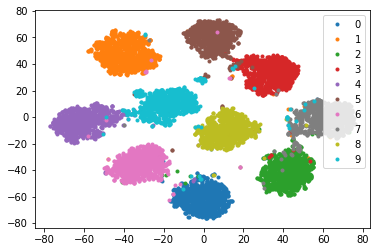

In [ ]:
# data loader
val_loader = get_loader(is_train=False, batch_size=2)

# 保存用
all_features = []
all_labels = []

# 推論
for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)

    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)
visualize(all_features, all_labels, 10)

### 0-4で学習

In [ ]:
# data
train_loader = get_loader_0to4(batch_size=64)

# model
model = Model().to(device)

# metric
metric = ArcMarginProduct(32, 10)
metric = metric.to(device)

# optimzer
optimizer = optim.SGD([{'params': model.parameters()}, {'params': metric.parameters()}], lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)

# CircleLoss
criterion = nn.CrossEntropyLoss()

# Training
model.train()
for epoch in range(20):
    sheduler.step()
    print("Training... Epoch = %d" % (epoch+1))
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        
        feature = model(img)
        pred = metric(feature, label)
        loss = criterion(pred, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training... Epoch = 1


100%|██████████| 479/479 [00:06<00:00, 75.79it/s]


Training... Epoch = 2


100%|██████████| 479/479 [00:06<00:00, 76.87it/s]


Training... Epoch = 3


100%|██████████| 479/479 [00:06<00:00, 76.74it/s]


Training... Epoch = 4


100%|██████████| 479/479 [00:06<00:00, 77.38it/s]


Training... Epoch = 5


100%|██████████| 479/479 [00:06<00:00, 77.17it/s]


Training... Epoch = 6


100%|██████████| 479/479 [00:06<00:00, 77.24it/s]


Training... Epoch = 7


100%|██████████| 479/479 [00:06<00:00, 77.43it/s]


Training... Epoch = 8


100%|██████████| 479/479 [00:06<00:00, 78.12it/s]


Training... Epoch = 9


100%|██████████| 479/479 [00:06<00:00, 77.93it/s]


Training... Epoch = 10


100%|██████████| 479/479 [00:06<00:00, 78.35it/s]


Training... Epoch = 11


100%|██████████| 479/479 [00:06<00:00, 77.68it/s]


Training... Epoch = 12


100%|██████████| 479/479 [00:06<00:00, 76.96it/s]


Training... Epoch = 13


100%|██████████| 479/479 [00:06<00:00, 76.59it/s]


Training... Epoch = 14


100%|██████████| 479/479 [00:06<00:00, 78.06it/s]


Training... Epoch = 15


100%|██████████| 479/479 [00:06<00:00, 75.99it/s]


Training... Epoch = 16


100%|██████████| 479/479 [00:06<00:00, 77.31it/s]


Training... Epoch = 17


100%|██████████| 479/479 [00:06<00:00, 76.22it/s]


Training... Epoch = 18


100%|██████████| 479/479 [00:06<00:00, 75.90it/s]


Training... Epoch = 19


100%|██████████| 479/479 [00:06<00:00, 77.17it/s]


Training... Epoch = 20


100%|██████████| 479/479 [00:06<00:00, 77.24it/s]


100%|██████████| 5000/5000 [00:08<00:00, 606.83it/s]


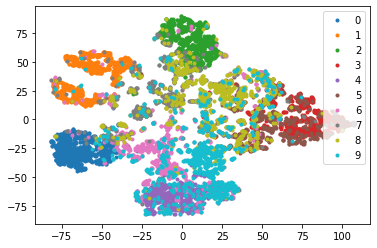

In [ ]:
# data loader
val_loader = get_loader(is_train=False, batch_size=2)

# 保存用
all_features = []
all_labels = []

# 推論
for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)

    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)
visualize(all_features, all_labels, 10)

### 0-7で学習

In [ ]:
# data
train_loader = get_loader_0to7(batch_size=64)

# model
model = Model().to(device)

# metric
metric = ArcMarginProduct(32, 10)
metric = metric.to(device)

# optimzer
optimizer = optim.SGD([{'params': model.parameters()}, {'params': metric.parameters()}], lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)

# CircleLoss
criterion = nn.CrossEntropyLoss()

# Training
model.train()
for epoch in range(20):
    sheduler.step()
    print("Training... Epoch = %d" % (epoch+1))
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        
        feature = model(img)
        pred = metric(feature, label)
        loss = criterion(pred, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training... Epoch = 1


100%|██████████| 754/754 [00:09<00:00, 76.89it/s]


Training... Epoch = 2


100%|██████████| 754/754 [00:09<00:00, 78.03it/s]


Training... Epoch = 3


100%|██████████| 754/754 [00:09<00:00, 76.63it/s]


Training... Epoch = 4


100%|██████████| 754/754 [00:09<00:00, 76.50it/s]


Training... Epoch = 5


100%|██████████| 754/754 [00:09<00:00, 76.82it/s]


Training... Epoch = 6


100%|██████████| 754/754 [00:09<00:00, 76.28it/s]


Training... Epoch = 7


100%|██████████| 754/754 [00:09<00:00, 76.29it/s]


Training... Epoch = 8


100%|██████████| 754/754 [00:09<00:00, 76.27it/s]


Training... Epoch = 9


100%|██████████| 754/754 [00:09<00:00, 76.46it/s]


Training... Epoch = 10


100%|██████████| 754/754 [00:09<00:00, 75.97it/s]


Training... Epoch = 11


100%|██████████| 754/754 [00:09<00:00, 75.88it/s]


Training... Epoch = 12


100%|██████████| 754/754 [00:09<00:00, 76.12it/s]


Training... Epoch = 13


100%|██████████| 754/754 [00:09<00:00, 75.62it/s]


Training... Epoch = 14


100%|██████████| 754/754 [00:09<00:00, 76.24it/s]


Training... Epoch = 15


100%|██████████| 754/754 [00:09<00:00, 76.49it/s]


Training... Epoch = 16


100%|██████████| 754/754 [00:09<00:00, 76.36it/s]


Training... Epoch = 17


100%|██████████| 754/754 [00:10<00:00, 74.34it/s]


Training... Epoch = 18


100%|██████████| 754/754 [00:09<00:00, 76.05it/s]


Training... Epoch = 19


100%|██████████| 754/754 [00:09<00:00, 75.91it/s]


Training... Epoch = 20


100%|██████████| 754/754 [00:09<00:00, 75.99it/s]


100%|██████████| 5000/5000 [00:08<00:00, 602.35it/s]


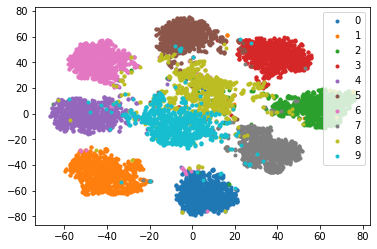

In [ ]:
# data loader
val_loader = get_loader(is_train=False, batch_size=2)

# 保存用
all_features = []
all_labels = []

# 推論
for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)

    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)
visualize(all_features, all_labels, 10)